# Emotion detection using Convolutional Neural Networks (CNN)

# Importing necessary libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential

from keras.optimizers import Adam,SGD,RMSprop

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.utils import class_weight

from google.colab import files

# Importing dataset

In [ ]:
# We need to use the opedatasets library to import datasets directly from Kaggle
!pip install opendatasets

In [ ]:
import opendatasets as od

In [ ]:
# Downloading the dataset from Kaggle to ensure we have the required data for training and testing our model
# My token from Kaggle is {"username":"rumon859","key":"23d432db09be9a99b54b83c498b90740"}
od.download("https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset")

Skipping, found downloaded files in "./face-expression-recognition-dataset" (use force=True to force download)


# Displaying pictures from the dataset

In [ ]:
# Setting the image size to 48x48 pixels
picture_size = 48

# Defining the folder path to the dataset to load training and validation images
folder_path = "./face-expression-recognition-dataset/images/"

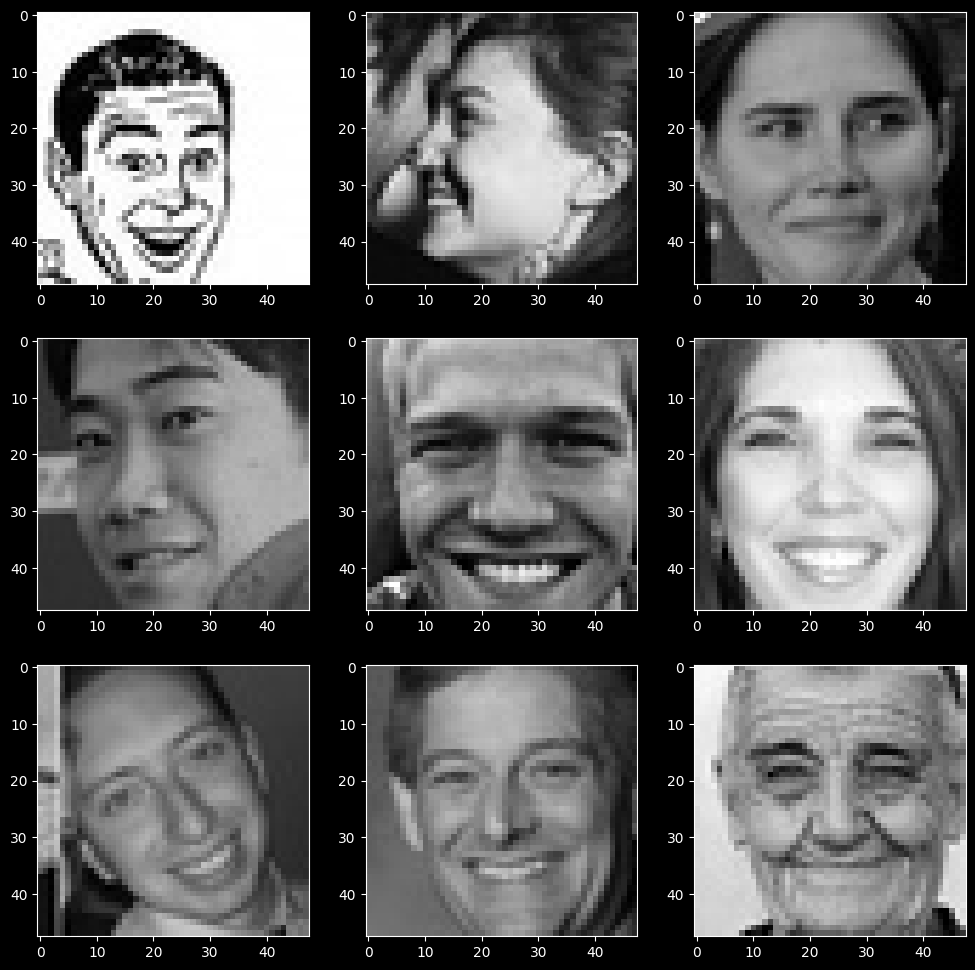

In [ ]:
# Visualizing sample images from the dataset to understand the data and check if the images are loaded correctly
expression = 'happy'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)
plt.show()

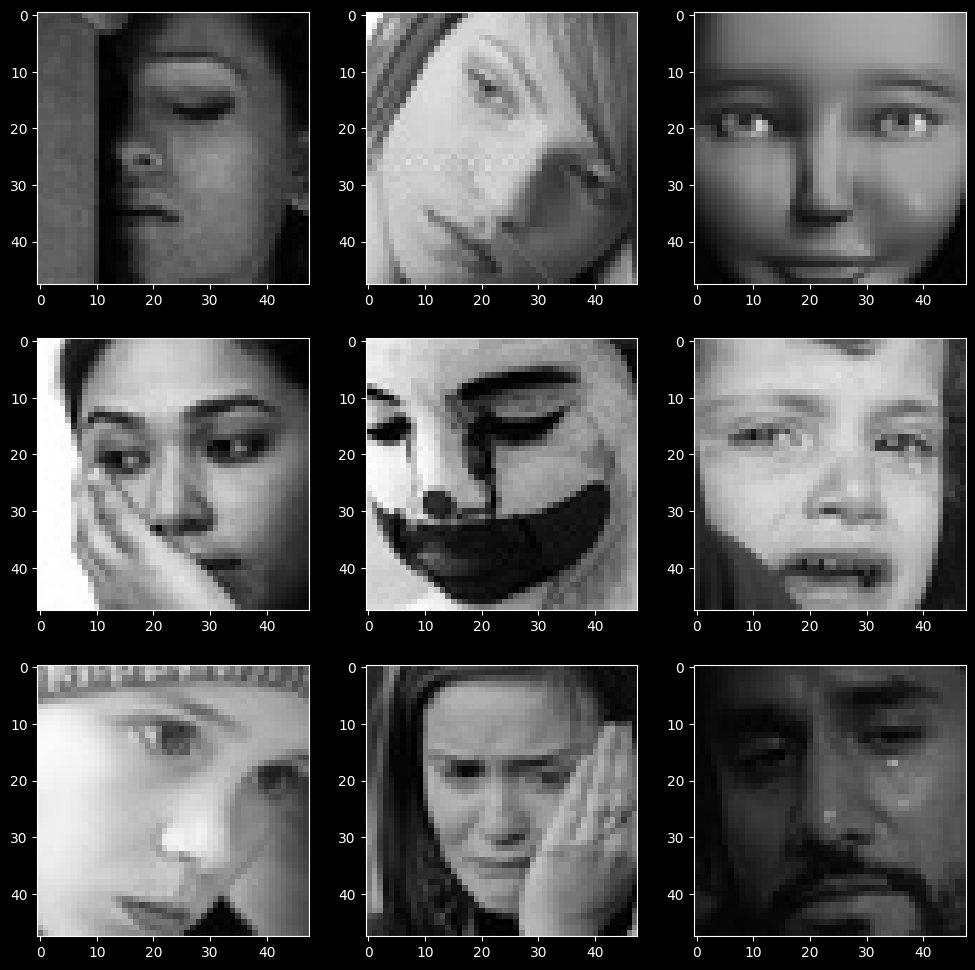

In [ ]:
# Visualizing sample images from the dataset to understand the data and check if the images are loaded correctly
expression = 'sad'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)
plt.show()

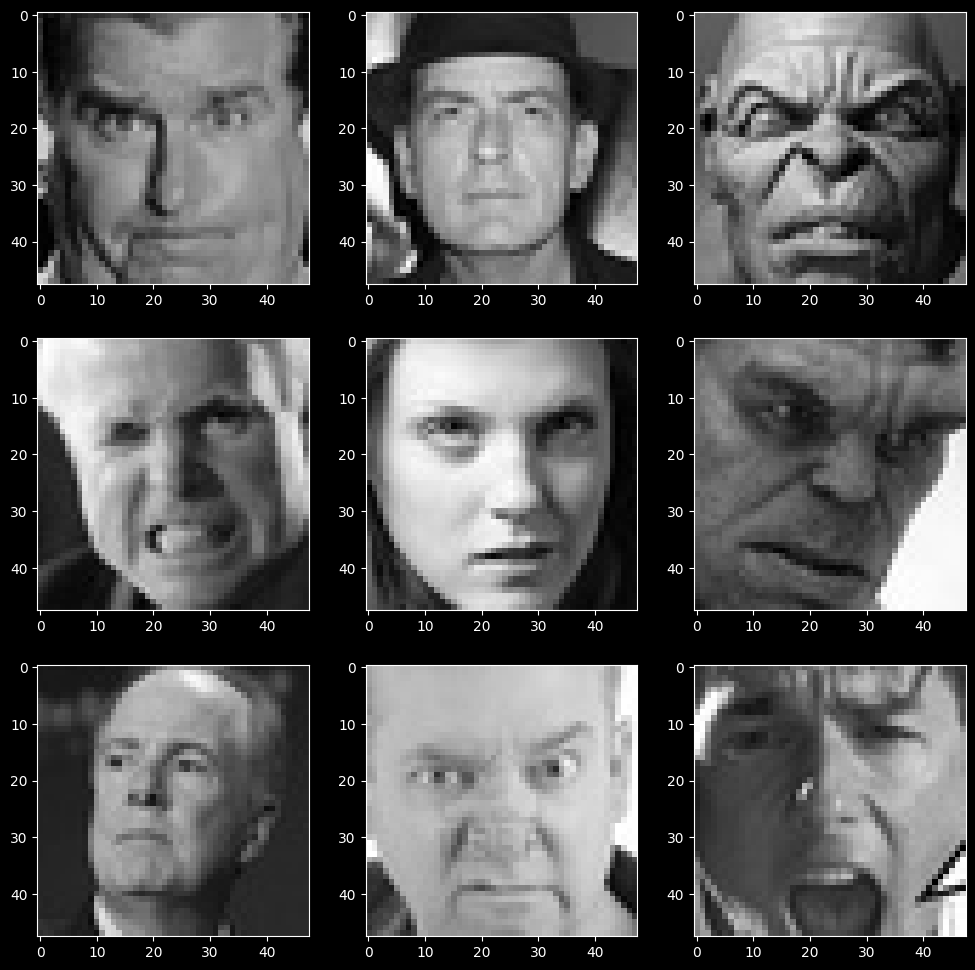

In [ ]:
# Visualizing sample images from the dataset to understand the data and check if the images are loaded correctly
expression = 'angry'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)
plt.show()

In [ ]:
# Printing out the kinds and number of images
for expression in os.listdir(folder_path + "train"):
    print(str(len(os.listdir(folder_path + "train/" + expression))) + " " + expression + " images")

3993 angry images
7164 happy images
4982 neutral images
436 disgust images
3205 surprise images
4103 fear images
4938 sad images


# Training and validation data

In [ ]:
#Setting batch size for training to balance between memory efficiency and training speed
batch_size  = 128

# Data augmentation for the training set to increase the diversity of training data and improve model generalization
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Rescaling validation set images without augmentation for evaluation
datagen_val = ImageDataGenerator(rescale=1./255)

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale", # Using grayscale images to reduce computational complexity
                                              batch_size=batch_size,
                                              class_mode='categorical', # Categorical class mode for multi-class classification
                                              shuffle=True) # Shuffle data to ensure random distribution of images in each batch


test_set = datagen_val.flow_from_directory(folder_path+"validation",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Creating a model

In [ ]:
# Defining the number of output classes for the classification task
no_of_classes = 7

# Building the CNN model for image classification to recognize facial expressions
model = Sequential()


# Adding convolutional layers to extract features from the images
# Each block of Conv2D, BatchNormalization, Activation, MaxPooling2D, and Dropout is used to build a deeper model while reducing overfitting

# 1st CNN layer

# Initial layer with input shape
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))

# Normalizing to accelerate training
model.add(BatchNormalization())

# ReLU activation for non-linearity
model.add(Activation('relu'))

# Downsample feature maps
model.add(MaxPooling2D(pool_size=(2, 2)))

# Droppingout to prevent overfitting
model.add(Dropout(0.25))

# 2nd CNN layer
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd CNN layer
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th CNN layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())

# Add fully connected layers to perform classification

# Fully connected layers
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Output layer with softmax activation for multi-class classification
model.add(Dense(no_of_classes, activation='softmax'))

In [ ]:
# Computing class weights for better predictions
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_set.classes),
    y=train_set.classes
)

# Converting class weights to a dictionary
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Inspecting the number of parameters and the structure of the neural network
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_20 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_20 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 24, 24, 128)      

# Fitting the model with the training and validation data

In [ ]:
# Defining callbacks for early stopping, checkpointing, and learning rate reduction to improve training efficiency and performance
checkpoint = ModelCheckpoint("./model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Stop training early if no improvement
early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

# Reduce learning rate if no improvement
reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 50

# Compiling the model with Adam optimizer and categorical cross-entropy loss for multi-class classification
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
# Training the model with the training set and validating with the validation set to evaluate performance
history = model.fit(
    train_set,
    steps_per_epoch=train_set.n // train_set.batch_size,
    epochs=epochs,
    validation_data=test_set,
    validation_steps=test_set.n // test_set.batch_size,
    class_weight=class_weights,
    callbacks=callbacks_list
)

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 2.0406 - accuracy: 0.1672
Epoch 1: val_accuracy improved from -inf to 0.01577, saving model to ./model.h5
225/225 [==============================] - 41s 169ms/step - loss: 2.0406 - accuracy: 0.1672 - val_loss: 2.2004 - val_accuracy: 0.0158 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 1.9740 - accuracy: 0.1840
Epoch 2: val_accuracy did not improve from 0.01577
225/225 [==============================] - 26s 116ms/step - loss: 1.9740 - accuracy: 0.1840 - val_loss: 2.1288 - val_accuracy: 0.0158 - lr: 0.0010
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 1.9235 - accuracy: 0.2027
Epoch 3: val_accuracy improved from 0.01577 to 0.19318, saving model to ./model.h5
225/225 [==============================] - 26s 116ms/step - loss: 1.9235 - accuracy: 0.2027 - val_loss: 2.0478 - val_accuracy: 0.1932 - lr: 0.0010
Epoch 4/50
225/225 [==============================] - ETA: 0s - loss: 1.8581 - accuracy: 0.2332
Epoch 4: val_accuracy improved from 0.19318 to 0.32145, saving model to ./model.h5
225/225 [==============================] - 26s 116ms/step - loss: 1.8581 - accuracy: 0.2332 - val_loss: 1.7020 - val_accuracy: 0.3214 - lr: 0.0010
Epoch 5/50
225/225 [==============================] - 

# Plotting accuracy and loss

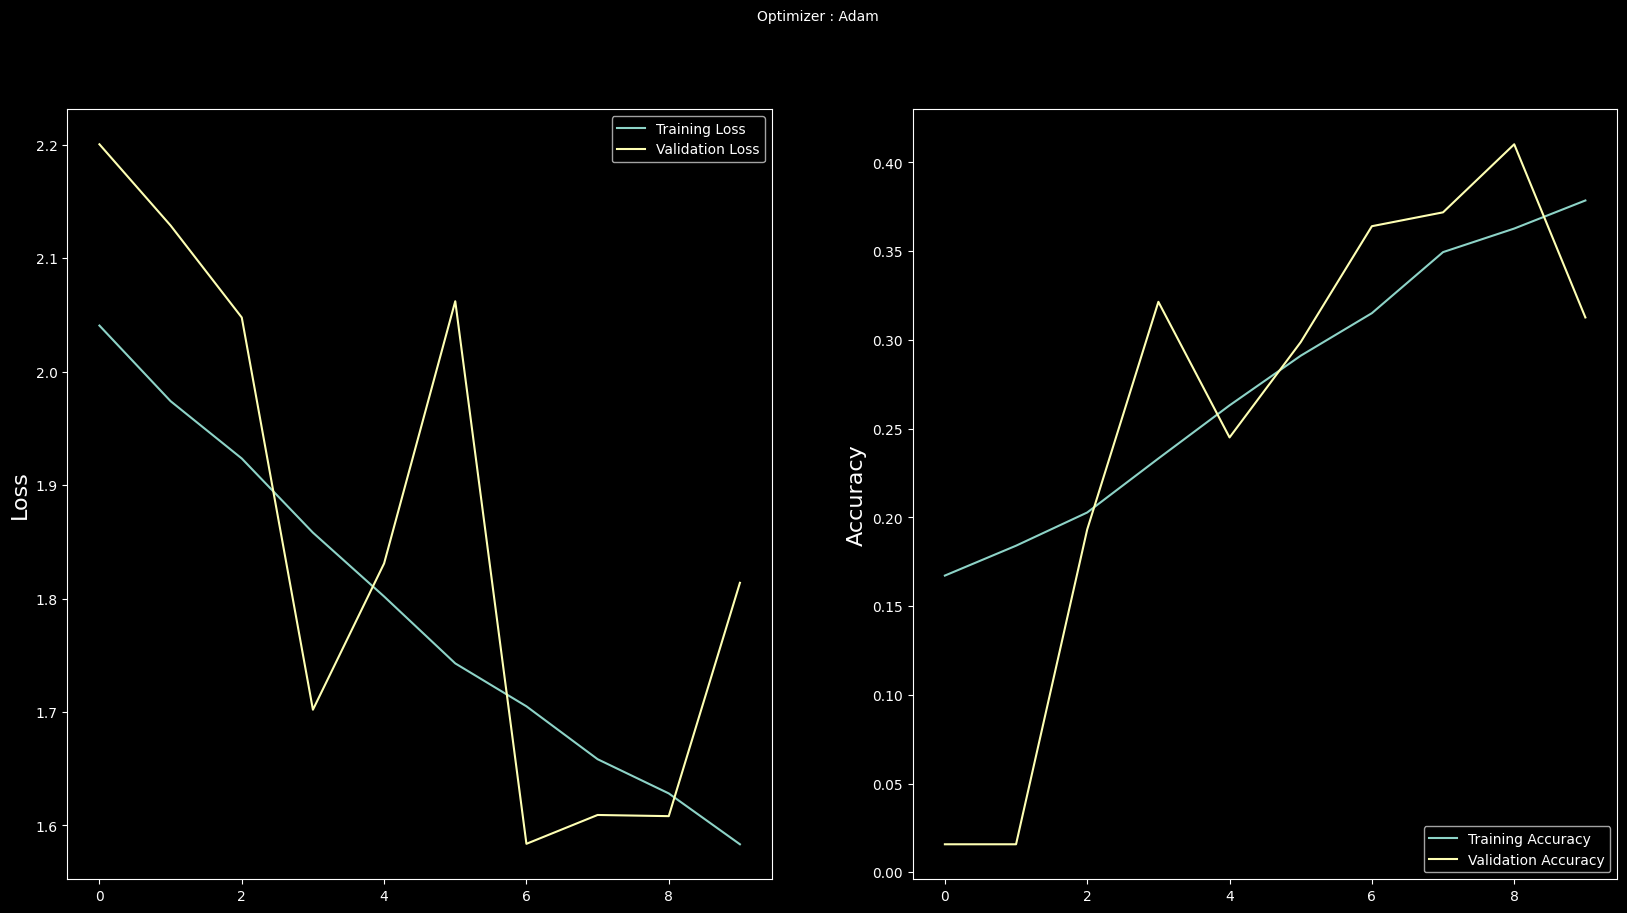

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Downloading the model to the local machine for later use or further analysis
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Trying a model without early stopping

In [ ]:
# Initializing a Sequential model
model_1= Sequential()

# Adding the first convolutional layer with 64 filters, a 3x3 kernel, 'same' padding, and input shape (48, 48, 1)
model_1.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

# Adding the second convolutional layer with 64 filters, a 3x3 kernel, 'same' padding, and input shape (48, 48, 1)
model_1.add(Conv2D(128, (3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Adding the third convolutional layer with 64 filters, a 3x3 kernel, 'same' padding, and input shape (48, 48, 1)
model_1.add(Conv2D(256, (3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

# Adding the fourth convolutional layer with 64 filters, a 3x3 kernel, 'same' padding, and input shape (48, 48, 1)
model_1.add(Conv2D(512, (3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

# Adding global average pooling to reduce each feature map to a single value
model_1.add(GlobalAveragePooling2D())

# Adding a dense (fully connected) layer with 256 units
model_1.add(Dense(256))

# Add batch normalization
model_1.add(BatchNormalization())

# Add ReLU activation function
model_1.add(Activation('relu'))

# Adding dropout
model_1.add(Dropout(0.25))

# Adding the output dense layer with 'no_of_classes' units and softmax activation for classification
model_1.add(Dense(no_of_classes, activation='softmax'))

In [ ]:
# # Setting the number of epochs to train the model
epochs = 50

model_1.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
# Training the model with the training data
model_1.fit(
    train_set,
    steps_per_epoch=train_set.n // train_set.batch_size,
    epochs=epochs,
    validation_data=test_set,
    validation_steps=test_set.n // test_set.batch_size,
    class_weight=class_weights
)

Epoch 1/50
225/225 [==============================] - 33s 126ms/step - loss: 2.0372 - accuracy: 0.1706 - val_loss: 1.9784 - val_accuracy: 0.1055
Epoch 2/50
225/225 [==============================] - 26s 116ms/step - loss: 1.9537 - accuracy: 0.1992 - val_loss: 2.0758 - val_accuracy: 0.2514
Epoch 3/50
225/225 [==============================] - 26s 116ms/step - loss: 1.8799 - accuracy: 0.2188 - val_loss: 1.7696 - val_accuracy: 0.3007
Epoch 4/50
225/225 [==============================] - 26s 117ms/step - loss: 1.8204 - accuracy: 0.2438 - val_loss: 1.7736 - val_accuracy: 0.3026
Epoch 5/50
225/225 [==============================] - 27s 119ms/step - loss: 1.7614 - accuracy: 0.2815 - val_loss: 2.2823 - val_accuracy: 0.2871
Epoch 6/50
225/225 [==============================] - 26s 116ms/step - loss: 1.7137 - accuracy: 0.3158 - val_loss: 2.1161 - val_accuracy: 0.1821
Epoch 7/50
225/225 [==============================] - 26s 117ms/step - loss: 1.6599 - accuracy: 0.3412 - val_loss: 2.1389 - val_ac

# Saving and downloading the model

In [ ]:
# Saving the trained model to a file named 'facial_emotion_recognition_model.h5'
model_1.save('facial_emotion_recognition_model.h5')

# Downloading the saved model file to the local machine
files.download('facial_emotion_recognition_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Frågor och svar


Fråga 1. Utmaningar du haft under arbetet samt hur du hanterat dem.

Svar: Det var svårt för mig att bestämma hur jag skulle välja vad som skulle justeras i modellen så att modellen skulle kunna göra bra prediktioner.



Fråga 2. Vilket betyg du anser att du skall ha och varför.

Svar: Jag har svarat på alla frågor för att bli godkänd i denna kurs. Efter det har jag skapat en känslodetekteringsmodell som kan upptäcka känslor på livekamera, och sedan lagt till ytterligare förtränade modeller som kan känna av kön och ålder, tillsammans med känslor (vänligen se bifogade fil "Live_Camera_Prediction"). Baserat på ovanstående faktorer är min förväntning att få VG-betyg :)


Fråga 3. Tips du hade ”gett till dig själv” i början av kursen nu när du slutfört den.

Svar: Jag har slösat bort massor av timmar med att träna min modell på Jupyter Notebook men till slut fungerade det inte. Å andra sidan är det väldigt enkelt och bekvämt att använda GPU på Google Colab. Så nästa gång kommer jag att använda Google Colab istället för Jupyter Notebook.

# Thank you so much! :)